# Air quality impact on hives survival 

The dataset is from Nectar 1.19 and cover hives from 2020 to 2023. The 2023 season is currently censored in terms of winter mortality but you can analyse the acute effect (which I didn't include in the blog post but I did have a look at the effect on the summer mortality and the effect are even stronger). I also shared the complete daily history for all the yards in the dataset for air quality , ndvi and weather that was scrapped from Airpyllution package, meteostats package and earth engine. Finally, you will find a file called 'ops_meta.csv' which contains the region of the given operations. 

The file are found on this google drive: [here](https://drive.google.com/drive/u/0/folders/1UZ3_jzMRdaQEaIR1TzPqEWTb0azECStB)


***
### SETUP

In [1]:
import os 
import ast
from datetime import datetime, date,timezone, timedelta

import pandas as pd 
import numpy as np
from collections import Counter

import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
from pymer4.models import Lmer
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

NECTAR_PALETTE = "blend:#D8A348,#1D1D1D"
sns.set_palette(NECTAR_PALETTE)

ROOT_PATH = "../data"
SEASONS_INCLUDED = [2021, 2022, 2023] # Don't include 2024 
FEATURES_MONTH = [4,5,6,7,8,9] # you might wanna change this since now lots of Califonrian in 2023
RUN_PREPROCESS = False # Only run when needed

BUFFER = 15 # Include winter deadout 15 days pass the season start 

START_SEASON_MONTH = 6
START_SEASON_DAY = 1
END_SEASON_MONTH = 11
END_SEASON_DAY = 15

# OPS USED 
OPS = (36, 51, 55, 69, 83, 87, 89, 153, 159, 160, 161, 167, 192, 193, 194, 195, 199, 205, 207, 208, 210, 212, 218, 219, 220, 221)
# you may wanna add more operation, I haven't updated this but we did have new comer end of year 2023 but doubt useful here since no data during season


In [2]:
from aqi.data.utils import timestamp_to_date, try_check_month
from aqi.vizualisation.utils import plot_survival_bar_per_state

In [3]:
if RUN_PREPROCESS:
    operation_meta = pd.read_csv(os.path.join(ROOT_PATH,"ops_meta.csv"))

    d = pd.read_csv(os.path.join(ROOT_PATH,"raw_dev.csv"))
                 
    d['death_date'] = pd.to_datetime(d['death_date'],format="mixed")
    d['creation_date'] = pd.to_datetime(d['creation_date'],format="mixed")
    i = 0
    for season in SEASONS_INCLUDED:
        for ops_id in d.operation_id.unique():
            ops = operation_meta.loc[operation_meta['id']==ops_id]
            
            season_end = date(season,END_SEASON_MONTH,END_SEASON_DAY)
            last_season_end = date(season-1,END_SEASON_MONTH,END_SEASON_DAY)

            start_month = ops['season_start_month'].values[0]
            start_day = ops['season_start_day'].values[0]
            
            season_start = date(season,start_month,start_day)
            next_season_start = date(season+1,start_month,start_day)
        
            state_logs = d.loc[d['operation_id']==ops_id]
            state_logs["death_date"]= state_logs["death_date"].fillna(next_season_start)
            state_logs["death_date"] = pd.to_datetime(state_logs["death_date"]).dt.tz_localize(None)
            state_logs["creation_date"] = pd.to_datetime(state_logs["creation_date"]).dt.tz_localize(
                None
            )
           
            created_during_season = (state_logs["creation_date"].dt.date < season_end) 
            # Died after the season start but was alive before
            died_after_season_start = state_logs["death_date"].dt.date >= season_start
            # Died before the next season 
            died_before_next_season_start = state_logs["death_date"].dt.date <= next_season_start + timedelta(days=BUFFER)
            # Exclude hive created betwween season start and that die before also 
            didnt_see_summer = ~((state_logs.apply(lambda x: x["death_date"].month in [1,2,3,4,5] ,axis=1)) & (state_logs["creation_date"].dt.date > season_end))
        
            
            subset_state = state_logs.loc[created_during_season & died_after_season_start & died_before_next_season_start & didnt_see_summer]
            subset_state['season'] = season
            # Also replace death date > then end_of_exp because otherwise bias model (age)
            subset_state.loc[pd.to_datetime(subset_state['death_date']).dt.date > next_season_start, 'death_date'] = next_season_start

            subset_state['season_start_month'] = start_month 
            subset_state['season_start_day'] = start_day
            
            if i == 0:
                data = subset_state 
                i = 1 
            else:
                data = pd.concat([data,subset_state],axis=0)
    data.reset_index(drop=True,inplace=True)
    data.to_csv(os.path.join(ROOT_PATH,"merged_dev.csv"),index=False)

***
### LOADING DATA

In [4]:
if RUN_PREPROCESS:
    aqi = pd.read_csv(os.path.join(ROOT_PATH,"aqi_dev.csv"))
    weather = pd.read_csv(os.path.join(ROOT_PATH,"weather_dev.csv"))
    ee = pd.read_csv(os.path.join(ROOT_PATH,"ee_dev.csv"))
    ee.drop("ee-image",axis=1,inplace=True)
    ee.dropna(subset=["ndvi"],inplace=True)
    
    mov = pd.read_csv(os.path.join(ROOT_PATH,"mouvements.csv"))

    data = pd.read_csv(os.path.join(ROOT_PATH,"merged_dev.csv"))
else:
    data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))
data['death_date'] = pd.to_datetime(data['death_date'], format='mixed')
data = data.loc[data['season'].isin(SEASONS_INCLUDED)]

In [5]:
# sns.set_palette("tab10")
# for ops in d.operation_id.unique():
#     if ops in [55,161,69]:
#         sub = d.loc[d['operation_id']==ops]
#         sns.histplot(sub.death_date.dt.month, label=str(ops))
# plt.legend()

In [6]:
sns.set_palette(NECTAR_PALETTE)

In [7]:
if RUN_PREPROCESS:
    print(weather.isnull().mean()) # For some reason atmost pressure is not getting scrapped 

In [8]:
if RUN_PREPROCESS:
    print(aqi.isnull().mean())

In [9]:
if RUN_PREPROCESS:
    print(ee.isnull().mean()) # 2023 is null , need to update for simulations later...

In [10]:
if RUN_PREPROCESS:
    print(ee.head())

In [11]:
if RUN_PREPROCESS:
    data['creation_date'] = pd.to_datetime(data['creation_date'],format='mixed').dt.date
    data['death_date']= pd.to_datetime(data['death_date']).dt.date

In [12]:
if RUN_PREPROCESS:
    print(Counter(data.hive_identity_id.value_counts())) # Meaning that 16 632 hives are present in two season while 38405 are only in one season 

In [13]:
if RUN_PREPROCESS:
    ### Label creation (based on season start end)
    
    def get_state_for_season(state_log):
        
        return state_log.apply(lambda x: (x['death_date'] + timedelta(days=BUFFER)) <= date(x['season']+1, x['season_start_month'],x['season_start_day']), axis=1)
    
    def get_age_for_season(state_log):
        return state_log.apply(lambda x : abs((x['death_date'] - x['creation_date']).days), axis=1)
    
    
    data['death_next_season'] = get_state_for_season(data)
    data['hive_age_next_season'] = get_age_for_season(data)

In [14]:
data['death_next_season'].mean()

0.35513235117978204

In [15]:
data.dtypes

hid                              int64
creation_date                   object
operation_id                     int64
death_date              datetime64[ns]
season                           int64
season_start_month               int64
season_start_day                 int64
death_next_season                 bool
hive_age_next_season             int64
aqhi_average                   float64
prcp_average                   float64
wspd_average                   float64
ndvi_average                   float64
tavg_average                   float64
o3_average                     float64
aqhi_skew                      float64
prcp_skew                      float64
wspd_skew                      float64
ndvi_skew                      float64
tavg_skew                      float64
o3_skew                        float64
aqhi_max                       float64
prcp_max                       float64
wspd_max                       float64
ndvi_max                       float64
tavg_max                 

In [16]:
data.operation_id.value_counts()

operation_id
193    41419
69     28613
153    19587
55     12354
167     7157
161     6881
87      5658
207     3613
177     1941
210     1610
195     1298
194      853
220      612
212      553
219      341
160      314
224      251
159      215
205      194
83       115
204        5
Name: count, dtype: int64

In [17]:
data.season.value_counts()

season
2023    102475
2022     24403
2021      6706
Name: count, dtype: int64

In [18]:
if RUN_PREPROCESS:
    # BAD OPS in 2021-2022
    data = data.loc[~((data['operation_id'] == 51) & (data['season']==2021))]
    data = data.loc[~((data['operation_id'] == 87) & (data['season']==2021))]
    data = data.loc[~((data['operation_id']==167) & (data['season']==2022))]

In [19]:
data.drop(['death_date','creation_date'],axis=1).groupby(['season','operation_id']).mean(numeric_only=True)[['death_next_season','hive_age_next_season']]

death_next_season  hive_age_next_season
season operation_id                                         
2021   55                     0.316870            303.664862
       69                     0.778855            352.086344
       83                     0.000000            277.000000
2022   55                     0.189252            530.274366
       69                     0.458318            357.938778
       83                     0.823529            336.882353
       87                     0.678105            256.837119
       153                    0.170213            371.130785
       159                    0.525000            258.187500
       160                    0.333333            251.757576
       161                    0.376853            181.977765
       177                    0.005089             93.740458
2023   55                     0.379773            679.800366
       69                     0.608972            503.032304
       83                     0.155556            743.111111
       87                     0.361939            373.476734
       153                    0.189475            533.823926
       159                    0.629630            372.288889
       160                    0.612903            417.487903
       161                    0.112736            439.982446
       167                    0.387453            188.097527
       177                    0.172294            379.661472
       193                    0.332867            271.111881
       194                    0.051583            154.887456
       195                    0.057011            162.412943
       204                    0.800000            237.200000
       205                    0.005155            203.247423
       207                    0.450872            129.685026
       210                    0.075155            243.935404
       212                    0.602170            101.043400
       219                    0.067449             97.475073
       220                    0.302288            183.339869
       224                    0.000000            178.940239

In [20]:
len(data)

133584

In [21]:
data.isnull().mean()

hid                     0.000000
creation_date           0.000000
operation_id            0.000000
death_date              0.000000
season                  0.000000
season_start_month      0.000000
season_start_day        0.000000
death_next_season       0.000000
hive_age_next_season    0.000000
aqhi_average            0.072524
prcp_average            0.072524
wspd_average            0.072524
ndvi_average            0.072524
tavg_average            0.072524
o3_average              0.072524
aqhi_skew               0.076431
prcp_skew               0.079680
wspd_skew               0.076109
ndvi_skew               0.076050
tavg_skew               0.076124
o3_skew                 0.076042
aqhi_max                0.072524
prcp_max                0.072524
wspd_max                0.072524
ndvi_max                0.072524
tavg_max                0.072524
o3_max                  0.072524
region                  0.000000
dtype: float64

### Feature eng for predictive models


### From mouvements to sensors data 

- Idea is to get the location of the hive at time X between june 1st and August 31 
- Once we have that info we simply do statistic on the sequence 


***
### One hive example

In [22]:
if RUN_PREPROCESS:
    mov['to_when'].fillna(date.today(),inplace=True) # When null still didn't moved
    mov['from_when'] = pd.to_datetime(mov['from_when'],format='mixed').dt.date
    mov['to_when'] = pd.to_datetime(mov['to_when'],format='mixed').dt.date
    
    aqi['time'] = pd.to_datetime(aqi['time'],format='mixed').dt.date
    weather['time'] = pd.to_datetime(weather['time'],format='mixed').dt.date
    ee['time'] = pd.to_datetime(ee['time'],format='mixed').dt.date

In [23]:
if RUN_PREPROCESS:
    # Only keep aqi, weather and ee for summer month 
    
    aqi = aqi.loc[pd.to_datetime(aqi['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)
    weather = weather.loc[pd.to_datetime(weather['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)
    ee = ee.loc[pd.to_datetime(ee['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)

In [24]:
if RUN_PREPROCESS:
    one = mov.loc[mov['hive_identity_id']==21199]
    print(len(one))

In [25]:
if RUN_PREPROCESS:
    one = (one.assign(time = [pd.date_range(start, end) 
                       for start, end 
                       in zip(one['from_when'], one['to_when'])]
              )
       .explode('time', ignore_index = True)
    )

In [26]:
if RUN_PREPROCESS:
    one['time'] = pd.to_datetime(one['time']).dt.date

In [27]:
if RUN_PREPROCESS:
    one.head()

In [28]:
if RUN_PREPROCESS:
    one = pd.merge(one,aqi, on=["yard_id","time"])

In [29]:
if RUN_PREPROCESS:
    one['season'] = pd.to_datetime(one['time']).dt.year
    one['month'] = pd.to_datetime(one['time']).dt.month

In [30]:
if RUN_PREPROCESS:
    one[['season','month','aqhi']].groupby(["season","month"]).mean()

In [31]:
if RUN_PREPROCESS:
    print(one.head())

### ALL hives and sensors

In [32]:
if RUN_PREPROCESS:
    mov = mov[mov['hive_identity_id'].isin(list(data.hive_identity_id.unique()))].reset_index(drop=True)

In [33]:
if RUN_PREPROCESS:
    # WARNING THIS TAKES A WHILE (15-30 minutes...or so)
    mov = (mov.assign(time = [pd.date_range(start,end) 
                       for start, end 
                       in zip(mov['from_when'], mov['to_when'])]
              )
       .explode('time', ignore_index = True)
    )

In [34]:
if RUN_PREPROCESS:
    mov['time'] = pd.to_datetime(mov['time']).dt.date
    
    mov = mov.loc[pd.to_datetime(mov['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)

In [35]:
if RUN_PREPROCESS:
    merged = pd.merge(mov,aqi, on=["yard_id","time"], how="left")
    merged = pd.merge(merged,weather, on=["yard_id","time"], how="left")
    merged = pd.merge(merged,ee, on=["yard_id","time"], how="left")
    merged.sort_values("time",ascending=True,inplace=True)
    # Keep value constant if no change 
    merged.fillna(method="bfill",inplace=True)
    
    merged.head()

In [36]:
if RUN_PREPROCESS:
    merged.isnull().mean()

### TSun and Wdir high null, just ignore them 

In [37]:
if RUN_PREPROCESS:
    merged.drop(['tsun','wdir'],axis=1,inplace=True)

### Compute stats for each hid

In [38]:
if RUN_PREPROCESS:
    merged['season'] = pd.to_datetime(merged['time']).dt.year

In [39]:
if RUN_PREPROCESS:
    # THis takes 10 min or so locally
    # merged['month'] = pd.to_datetime(merged['time']).dt.month
    averages = merged.drop(['from_when','to_when','time','submitted_at'],axis=1,errors="ignore").groupby(["hive_identity_id","season"]).mean().reset_index()
    skewed = merged.drop(['from_when','to_when','time','submitted_at'],axis=1,errors="ignore").groupby(["hive_identity_id","season"]).agg(lambda x : skew(x)).reset_index()
    maxed = merged.drop(['from_when','to_when','time','submitted_at'],axis=1,errors="ignore").groupby(["hive_identity_id","season"]).max().reset_index()
    mode = merged.drop(['from_when','to_when','time','submitted_at'],axis=1,errors="ignore").groupby(["hive_identity_id","season"]).mode().reset_index()

In [40]:
if RUN_PREPROCESS:
    averages.rename(columns={"aqhi":"aqhi_average","prcp":"prcp_average","wspd":"wspd_average","ndvi":"ndvi_average"
                             ,"tavg":"tavg_average","o3":"o3_average","hive_identity_id":"hid"},inplace=True)
    skewed.rename(columns={"aqhi":"aqhi_skew","prcp":"prcp_skew","wspd":"wspd_skew","ndvi":"ndvi_skew"
                           ,"tavg":"tavg_skew","o3":"o3_skew","hive_identity_id":"hid"},inplace=True)
    maxed.rename(columns={"aqhi":"aqhi_max","prcp":"prcp_max","wspd":"wspd_max","ndvi":"ndvi_max"
                          ,"tavg":"tavg_max","o3":"o3_max","hive_identity_id":"hid"},inplace=True)
    # mode.rename(columns={"aqhi":"aqhi_max","prcp":"prcp_max","wspd":"wspd_max","ndvi":"ndvi_max"
    #                       ,"tavg":"tavg_max","o3":"o3_max","hive_identity_id":"hid"},inplace=True)


In [41]:
if RUN_PREPROCESS:
    data.rename(columns={"hive_identity_id":"hid"},inplace=True)

### Bring remote sensors with season state (merge)

In [42]:
if RUN_PREPROCESS:
    print(len(data))
    data = pd.merge(data, averages[['season','hid','aqhi_average','prcp_average','wspd_average'
                                    ,'ndvi_average','tavg_average','o3_average']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, skewed[['season','hid','aqhi_skew','prcp_skew','wspd_skew'
                                  ,'ndvi_skew','tavg_skew','o3_skew']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, maxed[['season','hid','aqhi_max','prcp_max','wspd_max'
                                 ,'ndvi_max','tavg_max','o3_max']], on=["season","hid"], how="left")
    print(len(data))
    # data = pd.merge(data, mode[['season','hid','aqhi_max','prcp_max','wspd_max'
    #                              ,'ndvi_max','tavg_max','o3_max']], on=["season","hid"], how="left")

In [43]:
data.head()

,hid,creation_date,operation_id,death_date,season,season_start_month,season_start_day,death_next_season,hive_age_next_season,aqhi_average,...,ndvi_skew,tavg_skew,o3_skew,aqhi_max,prcp_max,wspd_max,ndvi_max,tavg_max,o3_max,region
0,36865,2021-09-20,55,2022-05-14,2021,5,14,False,236,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
1,16649,2021-05-19,55,2022-05-14,2021,5,14,False,360,2.533632,...,0.297063,-0.510858,0.687366,6.0,34.6,25.0,0.460514,26.7,104.845833,Unknown
2,14267,2021-05-08,55,2022-05-14,2021,5,14,False,371,2.602740,...,0.216794,-0.395353,0.657954,6.0,34.6,25.0,0.449957,27.2,104.845833,Unknown
3,16020,2021-05-17,55,2022-05-14,2021,5,14,False,362,2.580488,...,0.301466,-0.454580,0.719820,6.0,34.6,25.0,0.460514,26.7,104.845833,Unknown
4,16923,2021-05-25,55,2022-05-14,2021,5,14,False,354,1.946341,...,0.233874,-0.134386,0.669923,5.0,34.6,25.0,0.477245,26.7,88.303750,Unknown


In [44]:
len(data)

133584

### Add region

In [82]:
# if RUN_PREPROCESS:
operation_meta = pd.read_csv(os.path.join(ROOT_PATH,"ops_meta_loc.csv"))
operation_meta.index = operation_meta['Operation ID']
regions = operation_meta.to_dict(orient="dict")['Location']

In [83]:
regions

{193: 'Woodland, CA',
 192: 'Jennings, LA',
 69: 'Hay Lakes, AB',
 84: 'Turtle Lake, ND',
 167: 'Billerica, MA',
 55: 'Mirabel, QC',
 153: 'Coaldale, AB',
 51: 'Naches, WA',
 207: 'Myakka, FL',
 161: 'Saint-Sylvestre, QC',
 194: 'Worland, WY',
 87: 'Peace River, AB',
 208: 'Arbuckle, CA',
 210: 'Saint-Stanislas-de-Kostka, QC',
 160: 'Stewiacke, NS',
 195: 'Palo Cedro, CA',
 199: 'Hillsboro, KS',
 205: 'Fort Vermilion, AB',
 212: 'Chateaugay, NY',
 36: 'Spokane, WA',
 218: 'Youngsville, LA',
 45: 'Newcastle, CA',
 177: 'Jamestown, ND',
 159: 'Sherbrooke, QC',
 83: 'Montreal, QC'}

In [88]:
def try_region(x):
    try:
        return regions[int(x)].split(",")[1]
    except:
        return 'Unknown'

In [89]:
if RUN_PREPROCESS:
    data['region'] = data['operation_id'].apply(lambda x: try_region(x))
    data.groupby(['region','season']).count()

hid  creation_date  operation_id  death_date  \
region  season                                                   
 AB     2021     2269           2269          2269        2269   
        2022    14011          14011         14011       14011   
        2023    23635          23635         23635       23635   
 CA     2023    21036          21036         21036       21036   
 MA     2023       39             39            39          39   
 ND     2023      850            850           850         850   
 NS     2022       32             32            32          32   
        2023      161            161           161         161   
 QC     2021     2586           2586          2586        2586   
        2022     2129           2129          2129        2129   
        2023     6304           6304          6304        6304   
Unknown 2023        1              1             1           1   

                season_start_month  season_start_day  death_next_season  \
region  season                                                            
 AB     2021                  2269              2269               2269   
        2022                 14011             14011              14011   
        2023                 23635             23635              23635   
 CA     2023                 21036             21036              21036   
 MA     2023                    39                39                 39   
 ND     2023                   850               850                850   
 NS     2022                    32                32                 32   
        2023                   161               161                161   
 QC     2021                  2586              2586               2586   
        2022                  2129              2129               2129   
        2023                  6304              6304               6304   
Unknown 2023                     1                 1                  1   

                hive_age_next_season  aqhi_average  prcp_average  ...  \
region  season                                                    ...   
 AB     2021                    2269          2269          2269  ...   
        2022                   14011         14011         14011  ...   
        2023                   23635         23635         23635  ...   
 CA     2023                   21036         21036         21036  ...   
 MA     2023                      39            39            39  ...   
 ND     2023                     850           850           850  ...   
 NS     2022                      32            32            32  ...   
        2023                     161           161           161  ...   
 QC     2021                    2586          2586          2586  ...   
        2022                    2129          2129          2129  ...   
        2023                    6304          6304          6304  ...   
Unknown 2023                       1             1             1  ...   

                aqhi_max  prcp_max  wspd_max  ndvi_max  tavg_max  o3_max  \
region  season                                                             
 AB     2021        2269      2269      2269      2269      2269    2269   
        2022       14011     14011     14011     14011     14011   14011   
        2023       23635     23635     23635     23635     23635   23635   
 CA     2023       21036     21036     21036     21036     21036   21036   
 MA     2023          39        39        39        39        39      39   
 ND     2023         850       850       850       850       850     850   
 NS     2022          32        32        32        32        32      32   
        2023         161       161       161       161       161     161   
 QC     2021        2586      2586      2586      2586      2586    2586   
        2022        2129      2129      2129      2129      2129    2129   
        2023        6304      6304      6304      6304      6304    6304   
Unknown 2023           1       

### Saving preprocess so we don't need to run every time

In [91]:
if RUN_PREPROCESS:
    data.to_csv(os.path.join(ROOT_PATH,"preprocess.csv"),index=False)
else:
    data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))

In [92]:
len(data)

133584

In [95]:
ONLY_WINTER = False
ONLY_INSEASON = False 
ACTIVE_ALL_AND_WINTER = True  # Blog post hypothesis 
if ONLY_WINTER or ONLY_INSEASON:
    assert ONLY_WINTER != ONLY_INSEASON, "choose one! or both False"
if ONLY_INSEASON or ACTIVE_ALL_AND_WINTER:
    assert ACTIVE_ALL_AND_WINTER != ONLY_INSEASON, "choose one! or both False"

# Reload and apply
data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))

### Remove bad data 

In [115]:
data = data.loc[~((data['season']==2023) & (data['operation_id'].isin([153,204,219,220,224])))]
print(len(data))

121107


In [116]:
if ONLY_WINTER:
    # Exclude in-season deadout , we are just looking at winter morta 
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['winter_deadout'] = data.apply(lambda x: x['death_date'] > date(int(x['season']),x['season_start_month'],x['season_start_day']),axis=1)
    data = data.loc[data['winter_deadout']].reset_index(drop=True)

if ONLY_INSEASON:
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['winter_deadout'] = data.apply(lambda x: x['death_date'].month in [6,7,8],axis=1)
    data = data.loc[~data['winter_deadout'] | ~data['death_next_season']].reset_index(drop=True)

if ACTIVE_ALL_AND_WINTER:
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['creation_date'] = pd.to_datetime(data['creation_date']).dt.date
    # This ensure the exposition rate is the full season (makes them comparable with the current approach)
    # data = data.loc[(data['creation_date'] <= data.apply(
    #     lambda x: date(int(x['season']),x['season_start_month']+1,x['season_start_day'])
    #                  ,axis=1)) \
    #         & (data['death_date'] > data['season'].apply(lambda x : date(int(x),END_SEASON_MONTH,END_SEASON_DAY)))]
    # data = data.reset_index(drop=True)


### Keep next year aside and exclude some abnormal data

In [117]:
next_year = data.loc[data['season']==2024].reset_index(drop=True)
if not ONLY_INSEASON:
    data = data.loc[data['season']!=2024].reset_index(drop=True)

In [118]:
len(data)

121107

In [120]:
data.season.value_counts()

season
2023    89998
2022    24403
2021     6706
Name: count, dtype: int64

In [121]:
data.isnull().mean()

hid                     0.000000
creation_date           0.000000
operation_id            0.000000
death_date              0.000000
season                  0.000000
season_start_month      0.000000
season_start_day        0.000000
death_next_season       0.000000
hive_age_next_season    0.000000
aqhi_average            0.070029
prcp_average            0.070029
wspd_average            0.070029
ndvi_average            0.070029
tavg_average            0.070029
o3_average              0.070029
aqhi_skew               0.074314
prcp_skew               0.077873
wspd_skew               0.073968
ndvi_skew               0.073902
tavg_skew               0.073984
o3_skew                 0.073893
aqhi_max                0.070029
prcp_max                0.070029
wspd_max                0.070029
ndvi_max                0.070029
tavg_max                0.070029
o3_max                  0.070029
region                  0.000000
dtype: float64

*** 
### Quick viz 

Just checking a bit the data for intuition

### Check different sensors bar chart

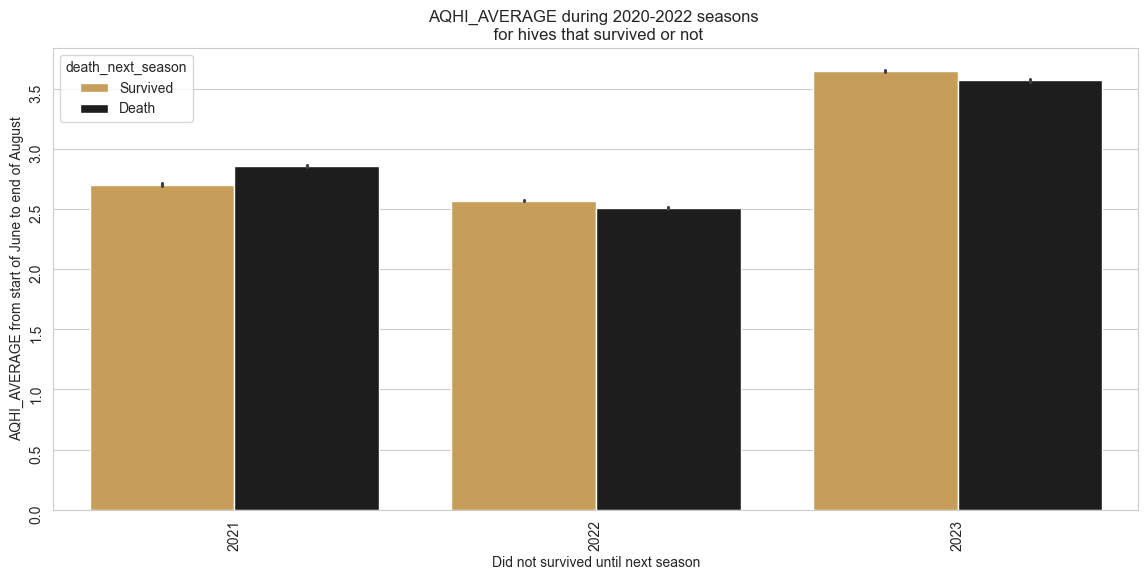

In [122]:
plot_survival_bar_per_state(data, "aqhi_average") # Bias by region for sure

### Check relation NDVI ~ AQHI


Idea is that increased vegetation should lead to less extreme AQHI value

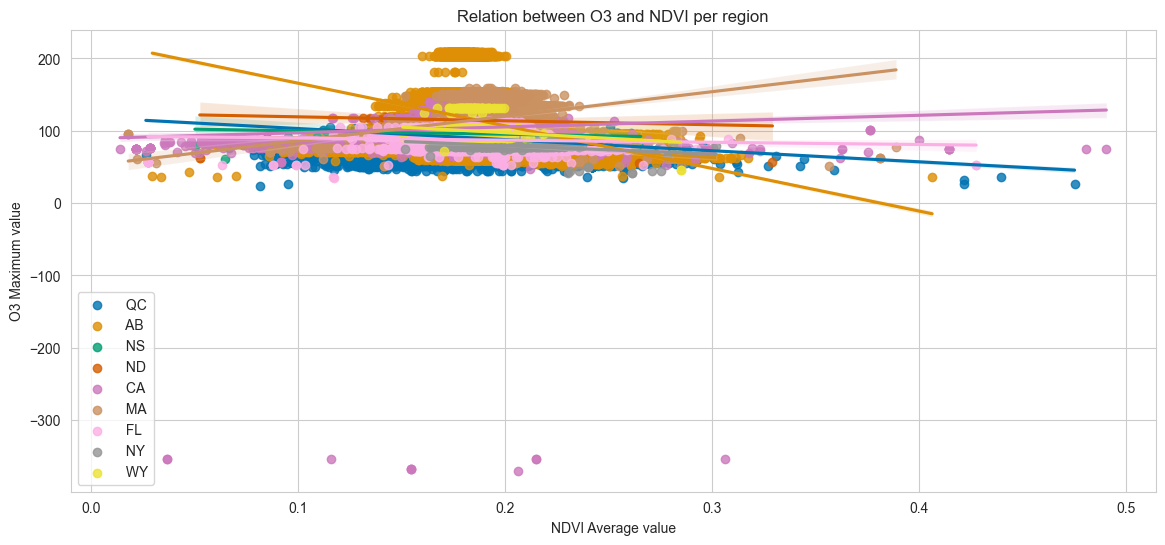

In [123]:
sns.set_palette('colorblind') # Otherwise very confusing 
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for s in data['region'].unique():
    sub = data.loc[data['region']==s]
    if len(sub) > 10:
        sns.regplot(x=sub["ndvi_average"], y=sub["o3_max"], label=s, ax=ax)
plt.ylabel("O3 Maximum value")
plt.xlabel("NDVI Average value")
plt.title("Relation between O3 and NDVI per region")
plt.legend()
plt.show()

<Axes: xlabel='ndvi_average', ylabel='aqhi_max'>

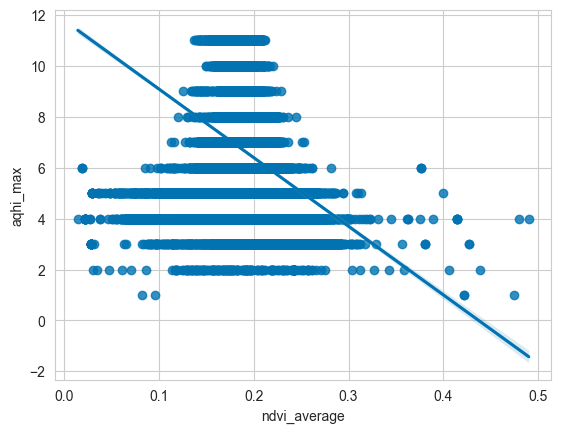

In [124]:
sns.regplot(x=data["ndvi_average"], y=data["aqhi_max"])

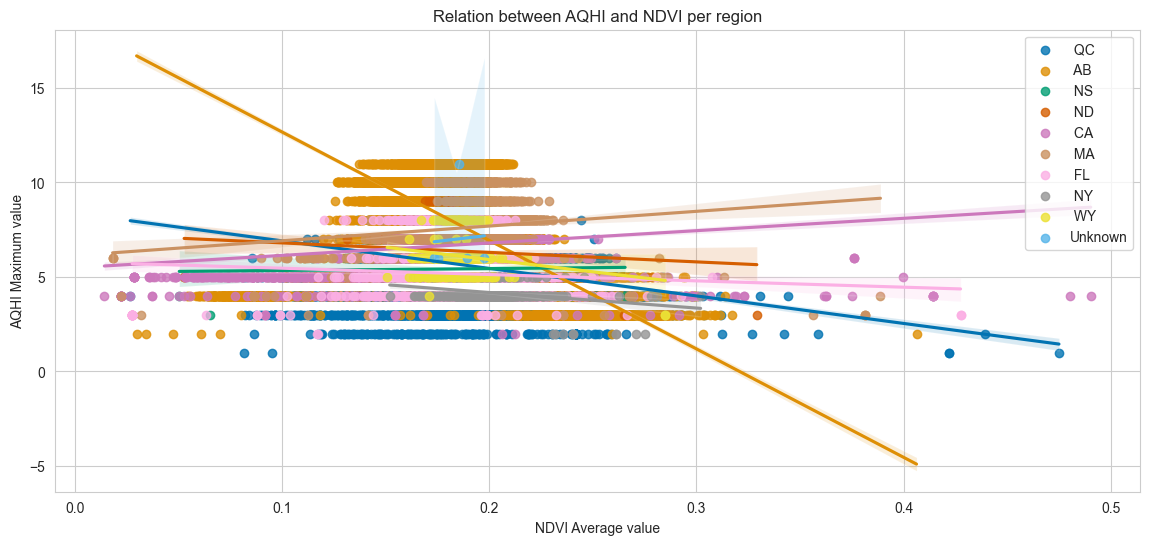

In [106]:
sns.set_palette('colorblind') # Otherwise very confusing 
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for s in data['region'].unique():
    sub = data.loc[data['region']==s]
    if len(sub) > 10:
        sns.regplot(x=sub["ndvi_average"], y=sub["aqhi_max"], label=s, ax=ax)
plt.ylabel("AQHI Maximum value")
plt.xlabel("NDVI Average value")
plt.title("Relation between AQHI and NDVI per region")
plt.legend()
plt.show()

### Check raw AQHI ~ mortality

Pattern for Quebec are different from the rest of the dataset

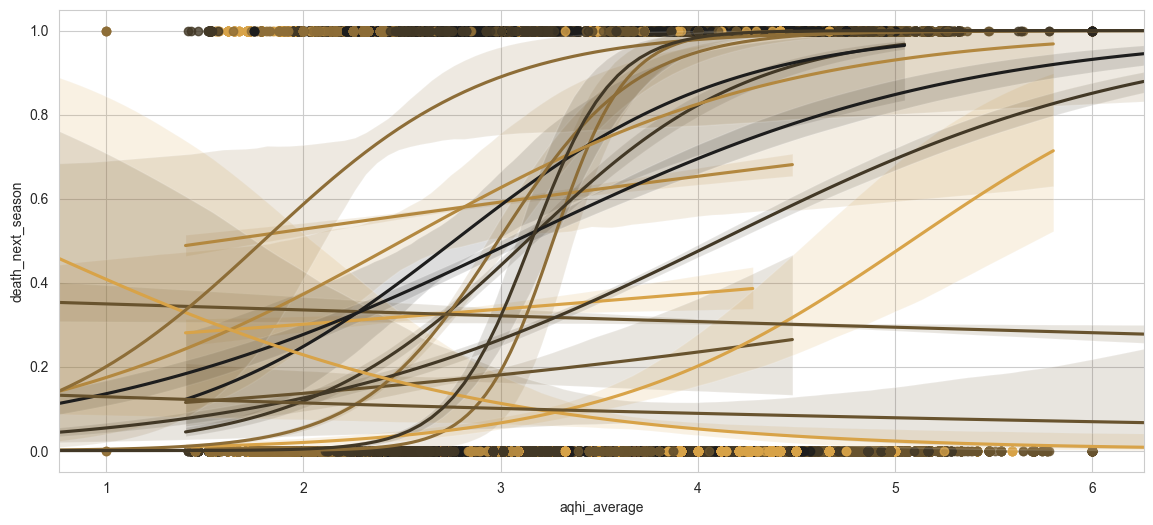

In [131]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for ops in data.operation_id.unique():
    subset = data.loc[data['operation_id']==ops]
    sns.regplot(x="aqhi_average",y="death_next_season",data=subset,logistic=True, truncate=False,label=ops, ax=ax)
plt.show()
plt.legend()

# This is starnge and may be due to hive located norther have faced more heavy aqhi ?

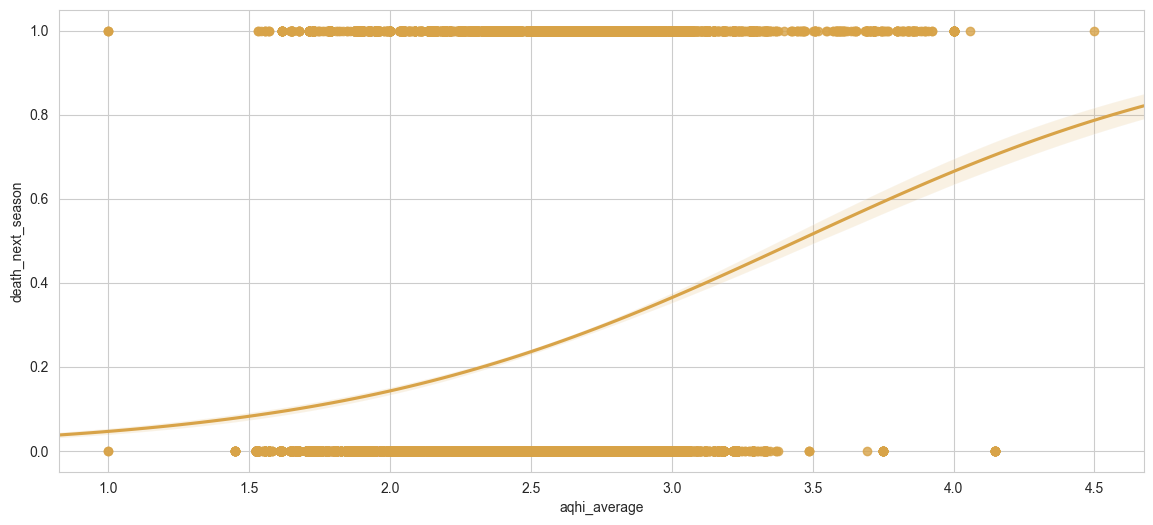

In [108]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data.loc[data['region']==" QC"],logistic=True, truncate=False, ax=ax)
plt.show()

# This is starnge and may be due to hive located norther have faced more heavy aqhi ?

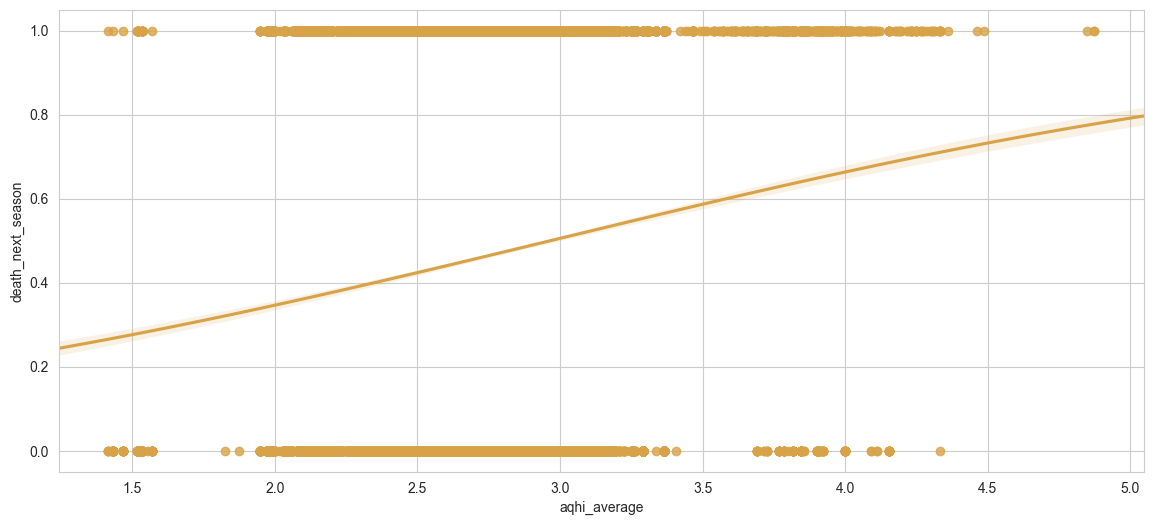

In [126]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data.loc[data['region']==" AB"],logistic=True, truncate=False, ax=ax)
plt.show()

*** 
### Check per region

In [132]:
data.region.value_counts()

region
 AB    42784
 CA    42717
 QC    21175
 MA     7157
 FL     3613
 ND     1941
 WY      853
 NY      553
 NS      314
Name: count, dtype: int64

In [133]:
data.groupby("region").mean(numeric_only=True)

,hid,operation_id,season,season_start_month,season_start_day,death_next_season,hive_age_next_season,aqhi_average,prcp_average,wspd_average,...,wspd_skew,ndvi_skew,tavg_skew,o3_skew,aqhi_max,prcp_max,wspd_max,ndvi_max,tavg_max,o3_max
region,,,,,,,,,,,,,,,,,,,,,
AB,85727.617918,88.330217,2022.457905,5.922681,5.573626,0.483452,417.214122,2.787246,2.406755,11.994017,...,1.221785,0.441441,-0.266923,-3.559296,7.333122,39.048852,30.596130,0.482912,24.801530,110.719459
CA,131098.922303,193.060772,2023.000000,1.000000,1.000000,0.324484,267.808952,4.384471,0.218593,10.843068,...,0.456993,0.468722,0.109024,-8.599653,6.667129,13.964530,23.161022,0.484777,31.079994,103.828538
FL,179423.129255,207.000000,2023.000000,1.000000,1.000000,0.450872,129.685026,2.936281,4.621789,12.224451,...,2.119772,0.307777,-0.339928,-4.598202,5.166914,59.184794,32.965132,0.441051,31.240600,87.414721
MA,162420.351963,167.000000,2023.000000,1.000000,1.000000,0.387453,188.097527,3.580570,3.965551,9.817316,...,0.777792,0.431189,-0.565691,-6.586579,7.620246,54.787700,22.316103,0.487510,26.562689,116.921207
ND,90797.596084,177.000000,2022.595054,1.000000,1.000000,0.104585,263.878928,3.279860,1.995574,13.796491,...,0.875546,0.465689,-0.643489,-7.633753,6.393819,40.836889,30.436790,0.470914,29.109472,114.885716
NS,111094.563694,160.000000,2022.789809,5.000000,1.000000,0.554140,382.652866,2.742338,2.796271,12.448203,...,0.512137,0.488226,-0.378356,-5.695204,5.424370,60.047479,24.728992,0.495493,25.342017,96.040716
NY,193044.320072,212.000000,2023.000000,1.000000,1.000000,0.602170,101.043400,2.382224,5.807928,12.402964,...,0.312764,0.367101,0.062618,-5.746579,4.176471,43.134118,19.741647,0.475762,23.900471,79.529643
QC,82424.386021,102.438772,2022.349705,4.588855,13.133932,0.254640,442.881700,2.502117,4.219540,10.736593,...,0.673105,0.417166,-0.455804,-3.545893,5.627544,43.751511,25.063700,0.481799,25.409789,89.688933
WY,179653.770223,194.000000,2023.000000,1.000000,1.000000,0.051583,154.887456,3.847484,1.194923,11.724818,...,0.968082,0.452522,-0.136380,-7.943947,6.121413,22.081015,24.630243,0.484537,28.976821,99.786129


In [134]:
# data = data.loc[data['region']!=' CA']
data.region.value_counts()

region
 AB    42784
 CA    42717
 QC    21175
 MA     7157
 FL     3613
 ND     1941
 WY      853
 NY      553
 NS      314
Name: count, dtype: int64

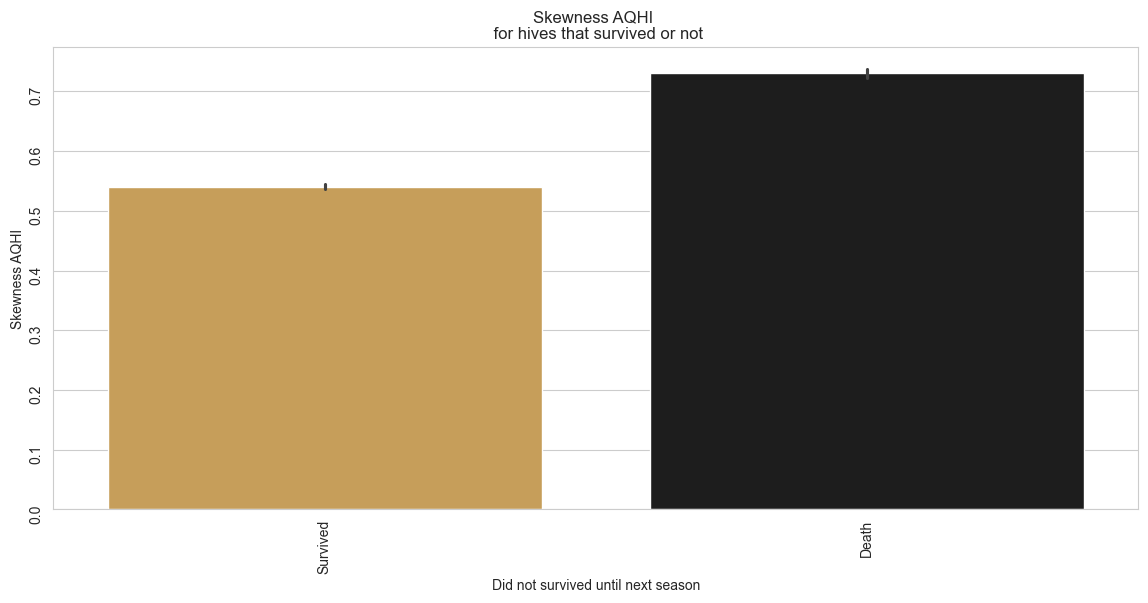

In [135]:
sns.set_style("whitegrid")
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax = sns.barplot(
    y=data['aqhi_skew'],x=data["death_next_season"].apply(lambda x : "Death" if x == 1 else "Survived"), ax=axes,
    palette="blend:#D8A348,#1D1D1D"#, errcolor="darkred"
)
#  
ax.set_ylabel("Skewness AQHI")
ax.set_xlabel("Did not survived until next season")
ax.tick_params(labelrotation=90)
plt.title("Skewness AQHI \n for hives that survived or not")
plt.show()

***
### DESCRIPTIVE STATS

In [136]:
data[['aqhi_average','ndvi_average']].isnull().mean()

aqhi_average    0.070029
ndvi_average    0.070029
dtype: float64

In [137]:
data.dropna(subset=['aqhi_average','ndvi_average'],axis=0,inplace=True) # Filling null value with zero

data['operation_id'] = data['operation_id'].astype(str)
data['season'] = data['season'].astype(str)

In [138]:
len(data)

112626

### Models 

In [139]:
data['wspd_average_og'] = data['wspd_average']
data['tavg_average_og'] = data['tavg_average']
data['prcp_average_og'] = data['prcp_average']
data['aqhi_average_og'] = data['aqhi_average']

data['wspd_average'] = np.log(data['wspd_average']+10e-5)
data['tavg_average'] = np.log(data['tavg_average']+10e-5)
data['prcp_average'] = np.log(data['prcp_average']+10e-5)
data['aqhi_average'] = np.log(data['aqhi_average']+10e-5)

<Axes: xlabel='aqhi_max', ylabel='Count'>

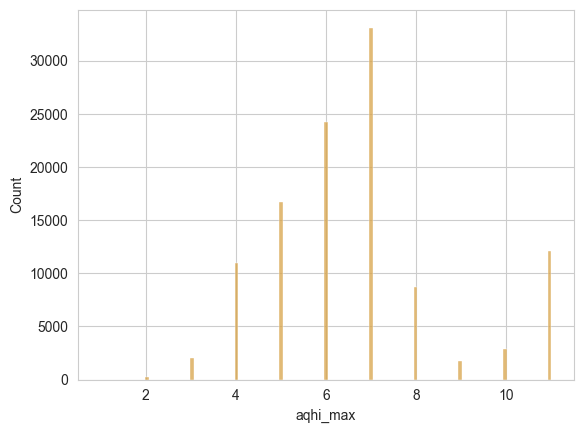

In [140]:
sns.histplot(data['aqhi_max'])

<Axes: xlabel='aqhi_average', ylabel='Count'>

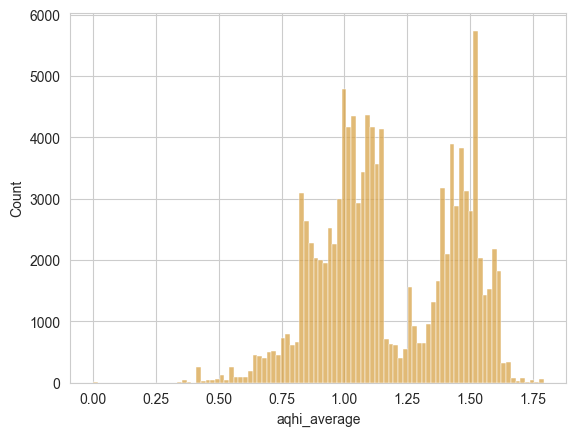

In [141]:
sns.histplot(data['aqhi_average'])

<Axes: xlabel='ndvi_average', ylabel='Count'>

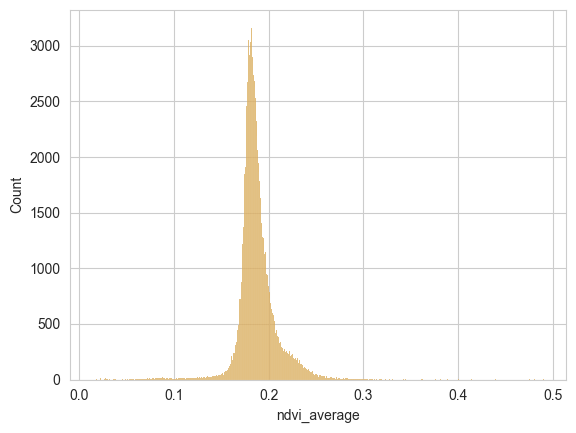

In [142]:
sns.histplot(data['ndvi_average'])

<Axes: xlabel='wspd_average', ylabel='Count'>

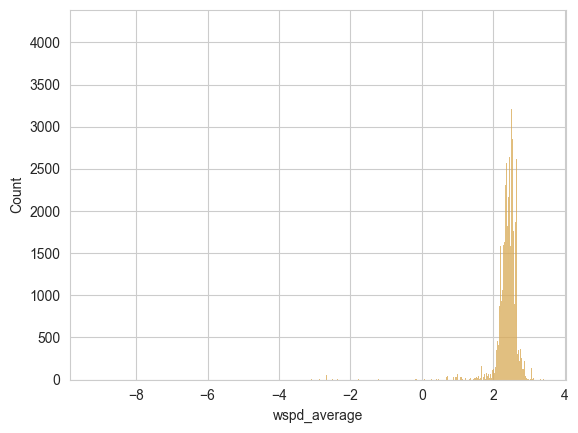

In [143]:
sns.histplot(data['wspd_average'])

In [144]:
data.death_next_season.mean()

0.36060945074849504

In [145]:
data.isnull().mean()

hid                     0.000000
creation_date           0.000000
operation_id            0.000000
death_date              0.000000
season                  0.000000
season_start_month      0.000000
season_start_day        0.000000
death_next_season       0.000000
hive_age_next_season    0.000000
aqhi_average            0.000000
prcp_average            0.000000
wspd_average            0.000000
ndvi_average            0.000000
tavg_average            0.000000
o3_average              0.000000
aqhi_skew               0.004608
prcp_skew               0.008435
wspd_skew               0.004235
ndvi_skew               0.004164
tavg_skew               0.004253
o3_skew                 0.004155
aqhi_max                0.000000
prcp_max                0.000000
wspd_max                0.000000
ndvi_max                0.000000
tavg_max                0.000000
o3_max                  0.000000
region                  0.000000
wspd_average_og         0.000000
tavg_average_og         0.000000
prcp_avera

### IF PackageNotInstalledError: The R package "lme4" is not installed. 

See REadme for instruction


```
from rpy2.robjects.packages import importr


utils = importr('utils')
utils.chooseCRANmirror(ind=12)
utils.install_packages('lme4')
```

In [148]:
model0 = Lmer("death_next_season  ~ 1 + (1|region)",
             data=data, family = 'binomial')

print(model0.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~1+(1|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -71157.617 	 AIC: 142319.235

Random effects:

               Name    Var    Std
region  (Intercept)  0.979  0.989

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -0.689  -1.035   -0.343  0.176  0.502      0.355        0.71   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.334        0.262         0.415  -3.904    0.0  ***  


In [149]:
model = Lmer("death_next_season  ~  aqhi_average*ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69346.746 	 AIC: 138707.492

Random effects:

                Name    Var    Std
region   (Intercept)  5.019  2.240
region  aqhi_average  2.563  1.601

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.814

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE          OR  \
(Intercept)                  -5.382  -6.878   -3.887  0.763       0.005   
aqhi_average                  6.843   5.716    7.970  0.575     937.135   
ndvi_average                 12.279  10.357   14.201  0.980  215114.880   
aqhi_average:ndvi_average   -24.978 -26.717  -23.239  0.887       0.000   

                           OR_2.5_ci   OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)                    0.001        0.021  

In [150]:
model2 = Lmer("death_next_season  ~ aqhi_average + ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model2.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average+ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69483.983 	 AIC: 138979.966

Random effects:

                Name    Var    Std
region   (Intercept)  6.045  2.459
region  aqhi_average  2.888  1.699

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.859

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -0.219  -1.791    1.352  0.802  0.803      0.167       3.865   
aqhi_average     2.083   0.946    3.220  0.580  8.030      2.576      25.035   
ndvi_average   -14.794 -15.576  -14.012  0.399  0.000      0.000       0.000   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.445        0.143         0.794  -0.274  0.784       
aqhi_average  0.889        0.720         

In [151]:
model3 = Lmer("death_next_season  ~ aqhi_average*ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model3.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69346.746 	 AIC: 138707.492

Random effects:

                Name    Var    Std
region   (Intercept)  5.019  2.240
region  aqhi_average  2.563  1.601

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.814

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE          OR  \
(Intercept)                  -5.382  -6.878   -3.887  0.763       0.005   
aqhi_average                  6.843   5.716    7.970  0.575     937.135   
ndvi_average                 12.279  10.357   14.201  0.980  215114.880   
aqhi_average:ndvi_average   -24.978 -26.717  -23.239  0.887       0.000   

                           OR_2.5_ci   OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)                    0.001        0.021  

In [152]:
model4 = Lmer("death_next_season  ~ aqhi_average + ndvi_average + tavg_average + prcp_average + wspd_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model4.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average+ndvi_average+tavg_average+prcp_average+wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -68446.787 	 AIC: 136911.575

Random effects:

                Name    Var    Std
region   (Intercept)  7.763  2.786
region  aqhi_average  2.953  1.718

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.882

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE         OR  OR_2.5_ci  \
(Intercept)      9.569   7.655   11.483  0.977  14315.644   2111.233   
aqhi_average     2.439   1.236    3.643  0.614     11.467      3.442   
ndvi_average    -8.511  -9.343   -7.678  0.425      0.000      0.000   
tavg_average    -3.915  -4.093   -3.736  0.091      0.020      0.017   
prcp_average    -0.046  -0.062   -0.030  0.008      0.955      0.940   
wspd_average     0.100   0.06

In [153]:
model5 = Lmer("death_next_season  ~ aqhi_average*wspd_average + ndvi_average + tavg_average + prcp_average   + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model5.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average+ndvi_average+tavg_average+prcp_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -68439.579 	 AIC: 136899.158

Random effects:

                Name    Var    Std
region   (Intercept)  7.758  2.785
region  aqhi_average  2.897  1.702

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.884

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE        OR  \
(Intercept)                   8.368   6.650   10.086  0.877  4306.192   
aqhi_average                  3.579   2.428    4.730  0.587    35.836   
wspd_average                  0.582   0.336    0.828  0.125     1.790   
ndvi_average                 -8.439  -9.270   -7.608  0.424     0.000   
tavg_average                 -3.919  -4.097   -3.741  0.091     0.020   
prcp_average           

In [154]:
model6 = Lmer("death_next_season  ~ aqhi_average*wspd_average*tavg_average + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model6.fit())

Model failed to converge with max|grad| = 0.00518092 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average*tavg_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -68338.861 	 AIC: 136699.722

Random effects:

                Name     Var    Std
region   (Intercept)  10.173  3.189
region  aqhi_average   5.106  2.260

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.909

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                7.334   5.490    9.178  0.941   
aqhi_average                               1.461   0.224    2.698  0.631   
wspd_average                             -12.484 -13.646  -11.322  0.593   
tavg_average                              -4.733  -5.547   -3.920  0.415   
aqhi_average:wspd_aver

In [155]:
model7a = Lmer("death_next_season  ~ aqhi_average*ndvi_average*wspd_average  + (ndvi_average|region) ",
             data=data, family = 'binomial')

print(model7a.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average*wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69439.475 	 AIC: 138900.951

Random effects:

                Name      Var     Std
region   (Intercept)   21.483   4.635
region  ndvi_average  791.456  28.133

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.968

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                              -15.552 -16.685  -14.419  0.578   
aqhi_average                              17.503  16.746   18.260  0.386   
ndvi_average                              57.278  53.838   60.719  1.755   
wspd_average                               3.868   3.393    4.343  0.242   
aqhi_average:ndvi_average                -75.276 -78.059  -72.493  1.420   
aqhi_average:wspd_aver

In [156]:
model7 = Lmer("death_next_season  ~ aqhi_average*ndvi_average + wspd_average + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model7.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69466.084 	 AIC: 138948.167

Random effects:

                Name      Var     Std
region   (Intercept)   20.090   4.482
region  ndvi_average  747.689  27.344

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.966

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE            OR  \
(Intercept)                  -6.178  -7.064   -5.292  0.452  2.000000e-03   
aqhi_average                  8.458   7.927    8.990  0.271  4.714200e+03   
ndvi_average                 17.646  14.936   20.356  1.383  4.609401e+07   
wspd_average                  0.088   0.051    0.124  0.019  1.091000e+00   
aqhi_average:ndvi_average   -36.669 -39.408  -33.929  1.398  0.000000e+00   

               

In [157]:
model8 = Lmer("death_next_season  ~ aqhi_average*ndvi_average*wspd_average + (aqhi_average|region) ",
             data=data, family = 'binomial')

print(model8.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average*wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69318.872 	 AIC: 138659.744

Random effects:

                Name    Var    Std
region   (Intercept)  5.133  2.266
region  aqhi_average  2.617  1.618

                IV1           IV2  Corr
region  (Intercept)  aqhi_average -0.82

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                              -10.450 -12.054   -8.845  0.819   
aqhi_average                              11.378  10.139   12.616  0.632   
ndvi_average                              33.991  30.786   37.196  1.635   
wspd_average                               2.099   1.686    2.512  0.211   
aqhi_average:ndvi_average                -45.814 -48.622  -43.006  1.433   
aqhi_average:wspd_average        

In [158]:
model9 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average*wspd_average + (aqhi_skew|region) ",
             data=data, family = 'binomial')
print(model9.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average*wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -68988.409 	 AIC: 137998.817

Random effects:

               Name    Var    Std
region  (Intercept)  1.706  1.306
region    aqhi_skew  0.600  0.774

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.689

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                             2.727   1.744    3.709  0.501   
aqhi_skew                              -2.754  -3.587   -1.921  0.425  

In [159]:
model10 = Lmer("death_next_season  ~ aqhi_skew*ndvi_skew  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model10.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_skew+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69549.952 	 AIC: 139113.904

Random effects:

               Name    Var    Std
region  (Intercept)  1.537  1.240
region    aqhi_skew  0.747  0.864

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.679

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)            -1.040  -1.858   -0.223  0.417  0.353      0.156   
aqhi_skew               0.710   0.091    1.328  0.316  2.034      1.096   
ndvi_ske

In [160]:
model11 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average + wspd_average  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model11.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average+wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69010.985 	 AIC: 138037.969

Random effects:

               Name    Var    Std
region  (Intercept)  1.719  1.311
region    aqhi_skew  0.663  0.815

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.687

Fixed effects:

                        Estimate  2.5_ci  97.5_ci     SE         OR  \
(Intercept)                2.443   1.554    3.331  0.453     11.503   
aqhi_skew                 -1.682  -2.320   -1.044  0.325      0.186   
ndvi

In [161]:
model12 = Lmer("death_next_season  ~ aqhi_max*ndvi_average + wspd_average  + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model12.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average+wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69955.917 	 AIC: 139927.834

Random effects:

                Name      Var     Std
region   (Intercept)   23.626   4.861
region  ndvi_average  955.196  30.906

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.988

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)               3.365   2.634    4.097  0.373  28.948     13.929   
aqhi_max                  0.060  -0.019    0.138  0.040   1.061      0.981   
ndvi_average            -25.151 -28.527  -21.775  1.722   0.000      0.000   
wspd_average              0.116   0.079    0.153  0.019   1.123      1.082   
aqhi_max:ndvi_average    -0.148  -0.575    0.279  0.218   0.863      0.563   

             

In [162]:
model13 = Lmer("death_next_season  ~ aqhi_average*wspd_average + ndvi_average  + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model13.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average+ndvi_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69595.609 	 AIC: 139207.218

Random effects:

                Name     Var     Std
region   (Intercept)   21.28   4.613
region  ndvi_average  875.21  29.584

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.978

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE      OR  \
(Intercept)                  -0.386  -1.471    0.698  0.553   0.679   
aqhi_average                  3.537   2.969    4.105  0.290  34.353   
wspd_average                  0.950   0.709    1.190  0.123   2.584   
ndvi_average                -24.295 -28.376  -20.214  2.082   0.000   
aqhi_average:wspd_average    -0.811  -1.037   -0.585  0.115   0.444   

                           OR_2.5_ci  OR_97.5_ci   Pro

In [163]:
model14 = Lmer("death_next_season  ~ aqhi_max*ndvi_average*wspd_average  + (ndvi_average|region) ",
             data=data, family = 'binomial')

print(model14.fit())

[1] "Model failed to converge with max|grad| = 0.0208452 (tol = 0.002, component 1)"
[2] " \n"                                                                           

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average*wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69912.271 	 AIC: 139846.542

Random effects:

                Name       Var     Std
region   (Intercept)    24.889   4.989
region  ndvi_average  1002.603  31.664

                IV1           IV2   Corr
region  (Intercept)  ndvi_aver

In [164]:
model15 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model15.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew*wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69691.481 	 AIC: 139404.962

Random effects:

                Name    Var    Std
region   (Intercept)  4.513  2.124
region  aqhi_average  2.223  1.491

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.785

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            -6.432  -7.998   -4.867  0.799   
aqhi_average                            5.239   3.926    6.

In [165]:
model16 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew + wspd_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model16.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew+wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -69708.179 	 AIC: 139432.359

Random effects:

                Name    Var    Std
region   (Intercept)  4.728  2.174
region  aqhi_average  2.401  1.549

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.796

Fixed effects:

                        Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)               -3.669  -5.045   -2.292  0.702   0.026      0.006   
aqhi_average               2.439   1.418    3.4

In [166]:
model17 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model17.fit())

Model failed to converge with max|grad| = 0.00491992 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -66149.218 	 AIC: 132320.435

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  36.491  6.041
operation_id  aqhi_average  26.073  5.106

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.973

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Int

In [167]:
model18 = Lmer("death_next_season  ~ aqhi_max*ndvi_average + aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model18.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average+aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -65339.892 	 AIC: 130699.785

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  30.258  5.501
operation_id  aqhi_average  23.375  4.835

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.966

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE      OR  \
(Intercept)                   1.341  -1.020    3.702  1.205   3.823   
aqhi_max                     -0.533  -0.608   -0.457  0.038   0.587   
ndvi_average                -27.328 -29.483  -25.174  1.099   0.000   
aqhi_average                  3.964   1.883    6.046  1.062  52.692   
wspd_average                 -0.105  -0.364    0.154  0.132   0.900   
aqhi_m

In [168]:
model19 = Lmer("death_next_season  ~ ndvi_average*aqhi_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model19.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -65733.251 	 AIC: 131480.502

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  37.673  6.138
operation_id  aqhi_average  27.394  5.234

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.974

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE       OR  \
(Intercept)                  -4.452  -6.480   -2.423  1.035    0.012   
ndvi_average                  0.837  -1.553    3.226  1.219    2.309   
aqhi_average                  6.366   4.623    8.108  0.889  581.506   
ndvi_average:aqhi_average   -17.662 -19.809  -15.516  1.095    0.000   

                           OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)          

In [169]:
model20 = Lmer("death_next_season  ~ ndvi_average*aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model20.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -65703.364 	 AIC: 131428.727

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  37.364  6.113
operation_id  aqhi_average  26.947  5.191

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.973

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                4.278   2.055    6.501  1.134   
ndvi_average                             -46.736 -50.568  -42.904  1.955   
aqhi_average                              -2.513  -4.453   -0.573  0.990   
wspd_average                              -3.685  -4.155   -3.214  0.240   
ndvi_average:aqhi_average                 32.607  28.901   36

In [170]:
model21 = Lmer("death_next_season  ~ ndvi_average*aqhi_average  + (1|operation_id)",
             data=data, family = 'binomial')

print(model21.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -66436.358 	 AIC: 132882.716

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  2.286  1.512

No random effect correlations specified

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE         OR  \
(Intercept)                  -4.352  -5.251   -3.453  0.458      0.013   
ndvi_average                 10.526   7.770   13.282  1.406  37274.142   
aqhi_average                  5.475   4.968    5.981  0.258    238.533   
ndvi_average:aqhi_average   -23.422 -25.958  -20.886  1.294      0.000   

                           OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)                    0.005       0.032  0.013        0.005   
ndvi_average                2368.062  586708.210  

In [171]:
model22 = Lmer("death_next_season  ~ ndvi_average*aqhi_average*wspd_average + (1|operation_id)",
             data=data, family = 'binomial')

print(model22.fit())

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average*wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -66377.312 	 AIC: 132772.625

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  2.352  1.534

No random effect correlations specified

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci      SE  \
(Intercept)                                2.625  -2.249    7.499   2.487   
ndvi_average                             -30.869 -56.596   -5.142  13.126   
aqhi_average                              -1.242  -5.725    3.241   2.287   
wspd_average                              -2.933  -4.926   -0.940   1.017   
ndvi_average:aqhi_average                 19.035  -5.2

In [172]:
model23 = Lmer("death_next_season  ~ ndvi_average*aqhi_average + wspd_average + (1|operation_id)",
             data=data, family = 'binomial')

print(model23.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -66387.695 	 AIC: 132787.390

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  2.346  1.532

No random effect correlations specified

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE         OR  \
(Intercept)                  -3.901  -4.808   -2.995  0.463      0.020   
ndvi_average                 10.368   7.633   13.104  1.396  31832.579   
aqhi_average                  5.514   5.009    6.019  0.258    248.043   
wspd_average                 -0.207  -0.246   -0.167  0.020      0.813   
ndvi_average:aqhi_average   -23.303 -25.846  -20.761  1.297      0.000   

                           OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)                    0.00

In [173]:
model24 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average  + (1|operation_id)",
             data=data, family = 'binomial')

print(model24.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -66515.599 	 AIC: 133041.198

Random effects:

                     Name    Var  Std
operation_id  (Intercept)  2.249  1.5

No random effect correlations specified

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)      0.954   0.199    1.709  0.385  2.596      1.220       5.522   
ndvi_average   -14.315 -15.076  -13.553  0.388  0.000      0.000       0.000   
aqhi_average     0.990   0.878    1.103  0.057  2.692      2.406       3.013   
wspd_average    -0.211  -0.250   -0.171  0.020  0.810      0.778       0.843   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.722        0.550         0.847   2.476  0.013    *  
ndvi_average  0.0

In [174]:
model25 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model25.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -65762.770 	 AIC: 131539.540

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  37.053  6.087
operation_id  aqhi_average  26.351  5.133

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.973

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -0.626  -2.865    1.613  1.142   0.535      0.057       5.016   
ndvi_average   -18.491 -19.382  -17.600  0.455   0.000      0.000       0.000   
aqhi_average     3.177   1.294    5.059  0.960  23.965      3.649     157.412   
wspd_average    -0.147  -0.188   -0.105  0.021   0.864      0.829       0.900   

               Prob  Prob_2.5_ci  P

In [175]:
model26 = Lmer("death_next_season  ~ ndvi_average + aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model26.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -65762.762 	 AIC: 131541.524

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  37.064  6.088
operation_id  aqhi_average  26.358  5.134

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.974

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE      OR  \
(Intercept)                  -0.586  -2.721    1.550  1.090   0.557   
ndvi_average                -18.492 -19.364  -17.620  0.445   0.000   
aqhi_average                  3.138   1.306    4.970  0.935  23.064   
wspd_average                 -0.164  -0.421    0.094  0.131   0.849   
aqhi_average:wspd_average     0.016  -0.224    0.256  0.123   1.016   

              

In [176]:
model27 = Lmer("death_next_season  ~ ndvi_average + o3_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model27.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+o3_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -64696.648 	 AIC: 129405.297

Random effects:

                     Name     Var    Std
operation_id  (Intercept)  55.101  7.423
operation_id   o3_average   0.023  0.151

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.983

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -2.113  -4.624    0.397  1.281  0.121      0.010       1.487   
ndvi_average   -18.412 -19.277  -17.547  0.441  0.000      0.000       0.000   
o3_average       0.096   0.044    0.148  0.027  1.101      1.045       1.160   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.108        0.010         0.598  -1.650  0.099    .  
ndvi_a

In [177]:
model28 = Lmer("death_next_season  ~ ndvi_average*o3_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model28.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -64652.788 	 AIC: 129319.575

Random effects:

                     Name     Var    Std
operation_id  (Intercept)  54.805  7.403
operation_id   o3_average   0.023  0.151

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.983

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                -4.995  -7.594   -2.395  1.326  0.007      0.001   
ndvi_average               -2.197  -5.404    1.010  1.636  0.111      0.004   
o3_average                  0.150   0.096    0.204  0.028  1.162      1.101   
ndvi_average:o3_average    -0.304  -0.364   -0.245  0.030  0.738      0.695   

                         OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci

In [178]:
model29 = Lmer("death_next_season  ~ ndvi_average*o3_average + wspd_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model29.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average+wspd_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -64613.071 	 AIC: 129242.142

Random effects:

                     Name     Var    Std
operation_id  (Intercept)  53.856  7.339
operation_id   o3_average   0.022  0.150

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.983

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                -4.549  -7.595   -1.503  1.554  0.011      0.001   
ndvi_average               -2.674  -5.632    0.283  1.509  0.069      0.004   
o3_average                  0.150   0.087    0.213  0.032  1.162      1.091   
wspd_average               -0.192  -0.233   -0.151  0.021  0.826      0.792   
ndvi_average:o3_average    -0.294  -0.349   -0.239  0.028

In [179]:
model30 = Lmer("death_next_season  ~ ndvi_average*o3_average*wspd_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model30.fit())

[1] "Model failed to converge with max|grad| = 0.0124069 (tol = 0.002, component 1)"
[2] " \n"                                                                           

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average*wspd_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -64579.417 	 AIC: 129180.833

Random effects:

                     Name     Var    Std
operation_id  (Intercept)  54.676  7.394
operation_id   o3_average   0.023  0.151

                      IV1         IV2   Corr
operati

In [180]:
model31 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average + tavg_average + prcp_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model31.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+tavg_average+prcp_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -64778.182 	 AIC: 129574.364

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  40.712  6.381
operation_id  aqhi_average  29.945  5.472

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.967

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE         OR  OR_2.5_ci  \
(Intercept)     10.732   8.488   12.975  1.145  45775.538   4855.779   
ndvi_average   -11.822 -12.751  -10.894  0.474      0.000      0.000   
aqhi_average     3.140   1.213    5.067  0.983     23.102      3.363   
wspd_average    -0.155  -0.196   -0.113  0.021      0.857      0.822   
tavg_average    -4.260  -4.455   -4.064  0.100      0.0

In [181]:
model32 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average*wspd_average  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model32.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average*wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'region': 9.0}

Log-likelihood: -68988.409 	 AIC: 137998.817

Random effects:

               Name    Var    Std
region  (Intercept)  1.706  1.306
region    aqhi_skew  0.600  0.774

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.689

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                             2.727   1.744    3.709  0.501   
aqhi_skew                              -2.754  -3.587   -1.921  0.425  

In [182]:
model33 = Lmer("death_next_season  ~ ndvi_average*aqhi_average + aqhi_max*wspd_average + tavg_average*prcp_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model33.fit())

Model failed to converge with max|grad| = 0.0143352 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+aqhi_max*wspd_average+tavg_average*prcp_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -64460.009 	 AIC: 128946.019

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  36.624  6.052
operation_id  aqhi_average  27.972  5.289

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.963

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE        OR  \
(Intercept)                   7.036   4.973    9.098  1.052  1136.443   
ndvi_average                 -9.729 -12.201   -7.257  1.261     0.000   
aqhi_average                  4.260   2.478    6.042  0.909    70.828   
aqhi_max                      0.4

### Pick best model based on AIC

In [196]:
i = 0
best_aic = model0.AIC
best_model = model0
for i,m in enumerate([model,model2,model3,model4,model5,model6,model7,model7a,model8,model9,model10
                      ,model11,model12,model13,model14,model15,model16,model17,model18, model19,model20, 
                      model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,
                     model31,model32,model33]):
    # Check if model converged first 
    try:
        logs = m.warnings[0]
    except:
        logs = ""
    if (len(m.warnings) == 0) | ( logs != "boundary (singular) fit: see help('isSingular')"):
        current_aic = m.AIC
        if current_aic < best_aic:
            print(f"Current best model is {i} with an AIC of {current_aic}")
            best_aic = current_aic
            best_model = m
    else:
        print(f"Model {i} did not converged")
    i+=1

Current best model is 0 with an AIC of 138707.4923682428
Current best model is 3 with an AIC of 136911.57493729336
Current best model is 4 with an AIC of 136899.15826006225
Current best model is 5 with an AIC of 136699.72192089708
Current best model is 17 with an AIC of 132320.4350108986
Current best model is 18 with an AIC of 130699.7849269726
Current best model is 27 with an AIC of 129405.29656870816
Current best model is 28 with an AIC of 129319.57525913711
Current best model is 29 with an AIC of 129242.14239988054
Current best model is 30 with an AIC of 129180.83330641028
Current best model is 33 with an AIC of 128946.01892339165


In [197]:
best_model.summary()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+aqhi_max*wspd_average+tavg_average*prcp_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 112626	 Groups: {'operation_id': 17.0}

Log-likelihood: -64460.009 	 AIC: 128946.019

Random effects:

                      Name     Var    Std
operation_id   (Intercept)  36.624  6.052
operation_id  aqhi_average  27.972  5.289

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.963

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),7.036,4.973,9.098,1.052,1136.443,144.528,8935.998,0.999,0.993,1.000,6.687,0.00,***
ndvi_average,-9.729,-12.201,-7.257,1.261,0.000,0.000,0.001,0.000,0.000,0.001,-7.714,0.00,***
aqhi_average,4.260,2.478,6.042,0.909,70.828,11.918,420.913,0.986,0.923,0.998,4.685,0.00,***
aqhi_max,0.400,0.287,0.513,0.058,1.492,1.332,1.670,0.599,0.571,0.625,6.933,0.00,***
wspd_average,1.039,0.799,1.280,0.123,2.827,2.223,3.596,0.739,0.690,0.782,8.476,0.00,***
tavg_average,-4.075,-4.281,-3.868,0.105,0.017,0.014,0.021,0.017,0.014,0.020,-38.700,0.00,***
prcp_average,-0.584,-0.849,-0.318,0.136,0.558,0.428,0.728,0.358,0.300,0.421,-4.302,0.00,***
ndvi_average:aqhi_average,-2.262,-4.522,-0.002,1.153,0.104,0.011,0.998,0.094,0.011,0.499,-1.962,0.05,*
aqhi_max:wspd_average,-0.226,-0.271,-0.181,0.023,0.798,0.762,0.835,0.444,0.433,0.455,-9.783,0.00,***
tavg_average:prcp_average,0.173,0.086,0.259,0.044,1.188,1.090,1.296,0.543,0.521,0.564,3.898,0.00,***


<Axes: xlabel='Estimate'>

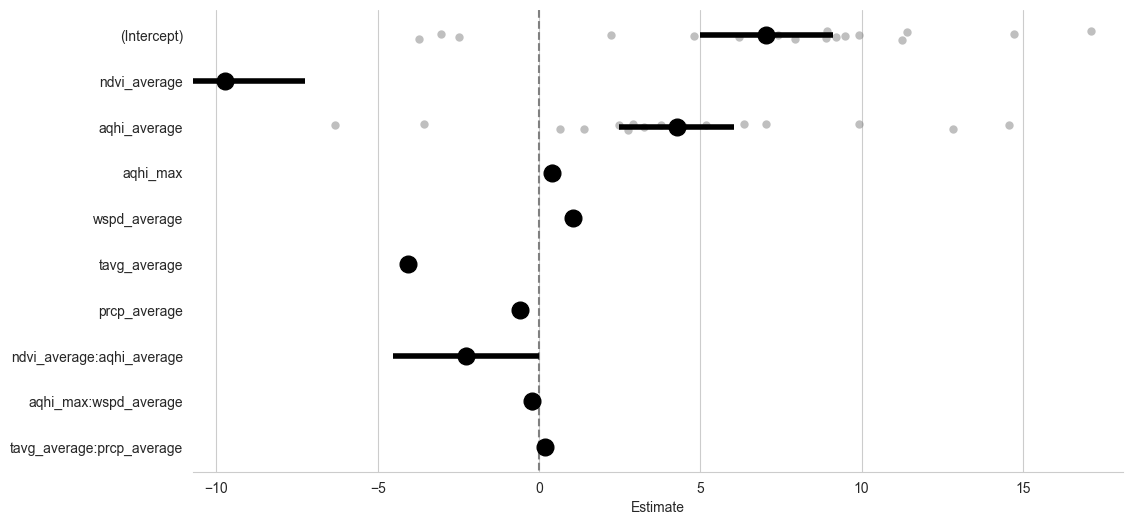

In [198]:
best_model.plot_summary()

### Higher skewness , means that death hive have right skewed distribution (more positive value)

Let's check these distribution of average (which is an aggregate but should show similar pattern)

<Axes: xlabel='aqhi_average_og', ylabel='Density'>

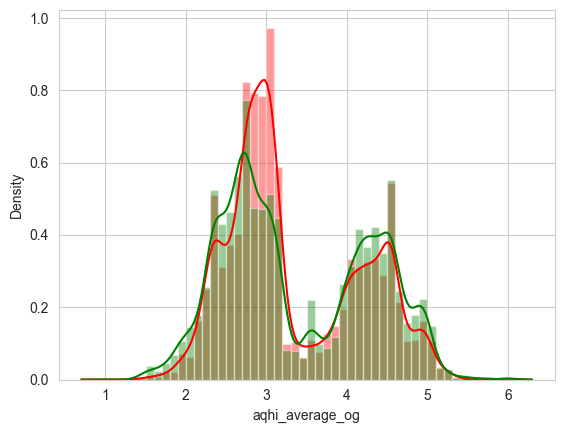

In [186]:
sns.distplot(data.loc[data['death_next_season']]['aqhi_average_og'], label="Death", color="red")
sns.distplot(data.loc[~data['death_next_season']]['aqhi_average_og'], label="Alive",color="green")

### Shallow learning approach 

In [187]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 40,60]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 20, 40,60]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [188]:
features = ['aqhi_average_og','tavg_average_og','tavg_max','tavg_skew'
            ,'wspd_average_og','wspd_skew','wspd_max','ndvi_skew','ndvi_max','ndvi_average'
            ,'prcp_average_og','prcp_skew','prcp_max']
data.season.value_counts()

season
2023    84056
2022    22640
2021     5930
Name: count, dtype: int64

In [189]:

mx=StandardScaler()

gr = pd.get_dummies(data['region'])
X = data.dropna(subset=['death_next_season','hive_age_next_season'],axis=0)
X.fillna(0,inplace=True)
X = X[features]
X = pd.concat([X,gr],axis=1)

data['death_next_season'] = data['death_next_season'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    np.array(data.apply(lambda x: (x["death_next_season"], x["hive_age_next_season"]), axis=1).tolist(),dtype=[('cens', '?'), ('time', '<f8')]),
    test_size=0.15,
    random_state=8,
)

X_train = mx.fit_transform(X_train)
X_test = mx.transform(X_test)



In [190]:

rf = RandomSurvivalForest()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=5,
    cv=3,
    verbose=1,
    random_state=8,
    n_jobs=-1,
)
# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: 

In [ ]:
rsf = rf_random.best_estimator_

In [ ]:
print("SCORE")
print(rsf.score(X_test,y_test))

sns.displot(rsf.predict(X_test))

### Evalutate

In [ ]:
va_times = np.arange(300, 550, 7)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, va_times
)


In [ ]:
plt.plot(va_times, rsf_auc, "--", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
# I want to add the mean AUC to the plot
plt.axhline(rsf_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.savefig("ROC.png")
plt.grid(True)

### FEature importance

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    rsf, X_test, y_test, n_repeats=15, random_state=8
)

pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X.columns
).sort_values(by="importances_mean", ascending=False)

### Checking correlation between predictor variables

In [ ]:
# Computing the correlation matrix
correlation_matrix1 = X.corr()

In [ ]:
# Displaying the correlation matrix
print(correlation_matrix1)

In [ ]:
correlation_matrix1.describe()

In [ ]:
# Creating a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig("Heath map RSF1.jpg", dpi=300)
plt.show()

In [ ]:
### To check and plot the minimal variable depth and importance for covariate interactions in the RSF1

In [ ]:
# Getting the trees from the RFS
trees = rsf.tree_

# Calculating variable depth and importance for covariate interactions
variable_depth = np.zeros(X.shape[1])
variable_importance = np.zeros(X.shape[1])

for tree in trees:
    # Traverse the tree to calculate variable depth and importance
    stack = [(0, 0)]  # (node_id, depth)
    
    while stack:
        node_id, depth = stack.pop()
        
        # If the node is not a leaf, traverse its children
        if tree.children_left[node_id] != tree.children_right[node_id]:
            stack.append((tree.children_left[node_id], depth + 1))
            stack.append((tree.children_right[node_id], depth + 1))
        else:
            # Accumulate variable depth and importance
            variable_depth[tree.feature[node_id]] += depth
            variable_importance[tree.feature[node_id]] += tree.impurity[node_id] * tree.n_node_samples[node_id]

# Normalizing variable importance
variable_importance /= np.sum(variable_importance)

# Plot
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(X.columns, variable_depth, alpha=0.7, label='Variable Depth', color='b')
ax2.plot(X.columns, variable_importance, label='Variable Importance', color='r')

ax1.set_xlabel('Covariates')
ax1.set_ylabel('Variable Depth', color='b')
ax2.set_ylabel('Variable Importance', color='r')

plt.title('Minimal Variable Depth and Importance for Covariate Interactions')
plt.savefig("MVD_IMP_RSF1.jpg", dpi=300)
plt.show()

### Random Forest 2 without Region

In [ ]:
mx=StandardScaler()
X2 = data.dropna(subset=['death_next_season','hive_age_next_season'],axis=0)
X2.fillna(0,inplace=True)
X2 = X2[features]

data['death_next_season'] = data['death_next_season'].asty2pe(bool)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2,
    np.array(data.apply(lambda x: (x["death_next_season"], x["hive_age_next_season"]), axis=1).tolist(),dty2pe=[('cens', '?'), ('time', '<f8')]),
    test_size=0.15,
    random_state=8,
)

X2_train = mx.fit_transform(X2_train)
X2_test = mx.transform(X2_test)

In [ ]:
rf2 = RandomSurvivalForest()
# I let the grid as you did
rf2_random = RandomizedSearchCV(
    estimator=rf2,
    param_distributions=random_grid,
    n_iter=5,
    cv=3,
    verbose=1,
    random_state=8,
    n_jobs=-1,
)
# Fit the random search model
rf2_random.fit(X2_train, y2_train)

In [ ]:
rsf2 = rf2_random.best_estimator_

print("Score RF2")
print(rsf2.score(X2_test,y2_test))

sns.displot(rsf2.predict(X2_test))

### EVALUATE

In [ ]:
va_times2 = np.arange(300, 550, 7)
rsf_chf_funcs2 = rsf2.predict_cumulative_hazard_function(
    X2_test, return_array=False)
rsf_risk_scores2 = np.row_stack([chf(va_times2) for chf in rsf_chf_funcs2])

rsf_auc2, rsf_mean_auc2 = cumulative_dynamic_auc(
    y2_train, y2_test, rsf_risk_scores2, va_times2
)

In [ ]:
plt.plot(va_times2, rsf_auc2, "--", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc2))
# I want to add the mean AUC to the plot
plt.axhline(rsf_mean_auc2, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.savefig("ROC2.png")
plt.grid(True)

### FEATURE IMPORTANCE

In [ ]:
from sklearn.inspection import permutation_importance
result2 = permutation_importance(
    rsf2, X2_test, y2_test, n_repeats=15, random_state=8
)

rsf2df = pd.DataFrame({k: result[k] for k in ("importances mean", "importances std",)},index=X2.columns).sort_values(by="importances mean", ascending=False)
# Save DataFrame to CSV
rsf2df.to_csv('RF2_variable_importance_results.csv')

### Checking correlation variables

In [ ]:
# Computing the correlation matrix
correlation_matrix2 = X2.corr()

In [ ]:
# Displaying the correlation matrix
print(correlation_matrix2)

In [ ]:
correlation_matrix2.describe()

In [ ]:
# Creating a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig("Heath map RSF2.jpg", dpi=300)
plt.show()

### To check and plot the minimal variable depth and importance for covariate interactions in the RSF2

In [ ]:
# Getting the trees from the RFS
trees2 = rsf2.tree_

# Calculating variable depth and importance for covariate interactions
variable_depth2 = np.zeros(X2.shape[1])
variable_importance2 = np.zeros(X2.shape[1])

for tree in trees2:
    # Traverse the tree to calculate variable depth and importance
    stack = [(0, 0)]  # (node_id, depth)
    
    while stack:
        node_id, depth = stack.pop()
        
        # If the node is not a leaf, traverse its children
        if tree.children_left[node_id] != tree.children_right[node_id]:
            stack.append((tree.children_left[node_id], depth + 1))
            stack.append((tree.children_right[node_id], depth + 1))
        else:
            # Accumulate variable depth and importance
            variable_depth2[tree.feature[node_id]] += depth
            variable_importance2[tree.feature[node_id]] += tree.impurity[node_id] * tree.n_node_samples[node_id]

# Normalizing variable importance
variable_importance2 /= np.sum(variable_importance2)

# Plot
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(X2.columns, variable_depth2, alpha=0.7, label='Variable Depth', color='b')
ax2.plot(X2.columns, variable_importance2, label='Variable Importance', color='r')

ax1.set_xlabel('Covariates')
ax1.set_ylabel('Variable Depth', color='b')
ax2.set_ylabel('Variable Importance', color='r')

plt.title('Minimal Variable Depth and Importance for Covariate Interactions')
plt.savefig("MVD_IMP_RSF2.jpg", dpi=300)
plt.show()


### Basic simulation

In [ ]:
def process(X, factor):
    X_copy = X.copy()
    X_copy[['aqhi_average_og']] = X[['aqhi_average_og']] * factor
    X_copy = mx.transform(X_copy)
    return X_copy
    

In [ ]:
def avg_surv_func(feat):
    surv = rsf.predict_survival_function(feat, return_array=True)
    return np.mean(surv,axis=0)

In [ ]:
X.head()

In [ ]:
preds = avg_surv_func(process(X, 1))
preds2 = avg_surv_func(process(X, 1.1))
preds3 = avg_surv_func(process(X, 1.5))
preds4 = avg_surv_func(process(X, 2))
preds8 = avg_surv_func(process(X, 4))


In [ ]:
predictions = np.stack([preds,preds2,preds3,preds4,preds8],axis=1,dtype=np.float32).flatten()
predictions.shape

In [ ]:
temps = []
for _ in [1.0,1.1,1.5,2.0,4.0]:
    temps.append([i for i in range(len(preds))])

In [ ]:
temps = np.stack(temps,axis=1).flatten()
temps.shape

In [ ]:
factor = []
for ii in [1.0,1.1,1.5,2.0,4.0]:
    f = []
    for _ in range(len(preds)):
        f.append([f"{ii}x"])
    factor.append(f)
factor = np.stack(factor,axis=1).flatten()
factor.shape

In [ ]:
results = pd.DataFrame({"Probabilité de survie":predictions,"Temps":temps, "Facteur":factor})
results.head()

In [ ]:
LANG = "EN"
title = {"FR":"Fonction de survie attendue dans des simulations \n d'intensification de mauvaise qualité de l'air",
         "EN":"Expected survival function for different simulations with varying air quality"}
xaxe = {"FR": "Temps (en jours)","EN":"Time (days)"}
yaxe = {"FR": "Probabilité de survie", "EN":"Probability of survival"}


sns.lineplot(x=results['Temps'], y=results['Probabilité de survie'], hue=results["Facteur"], linewidth=3, alpha=0.85, linestyle="solid")
plt.ylabel(yaxe[LANG])
plt.xlabel(xaxe[LANG])
plt.title(title[LANG])
plt.legend()
plt.grid(True)
plt.savefig(f"figure-2-{LANG}.png")

### Pred on 2023 true value

In [ ]:
next_year.head()

### Conclusion and next steps 

In [ ]:
next_year['wspd_average_og'] = next_year['wspd_average']
next_year['tavg_average_og'] = next_year['tavg_average']
next_year['prcp_average_og'] = next_year['prcp_average']
next_year['aqhi_average_og'] = next_year['aqhi_average']

next_year['wspd_average'] = np.log(next_year['wspd_average']+10e-5)
next_year['tavg_average'] = np.log(next_year['tavg_average']+10e-5)
next_year['prcp_average'] = np.log(next_year['prcp_average']+10e-5)
next_year['aqhi_average'] = np.log(next_year['aqhi_average']+10e-5)

In [ ]:
gr_next_year = pd.get_dummies(next_year['region'])
X_next_year = next_year.dropna(subset=['death_next_season','hive_age_next_season'],axis=0)
X_next_year.fillna(0,inplace=True)
X_next_year = X_next_year[features]
X_next_year = pd.concat([X_next_year,gr_next_year[gr.columns]],axis=1)

In [ ]:
X_next_year.head()

In [ ]:
transformed = mx.transform(X_next_year)

In [ ]:
surv23 = avg_surv_func(transformed)

In [ ]:
tim = [2023 for _ in range(len(surv23))]
tim.extend([2022 for _ in range(len(preds))])

In [ ]:
times = [i for i in range(len(surv23))]
times.extend([i for i in range(len(preds))])

In [ ]:
predics = surv23.tolist()
predics.extend(preds.tolist())

In [ ]:
ny = pd.DataFrame({"pred":predics, "year":tim, "time":times})
ny.head()

In [ ]:
LANG = "EN"
title = {"FR":"Fonction de survie attendue pour 2023",
         "EN":"Expected survival function for 2023"}
xaxe = {"FR": "Temps (en jours)","EN":"Time (days)"}
yaxe = {"FR": "Probabilité de survie", "EN":"Probability of survival"}


sns.lineplot(x=ny['time'], y=ny['pred'],hue=ny['year'],linewidth=3, alpha=0.85, linestyle="solid")
plt.ylabel(yaxe[LANG])
plt.xlabel(xaxe[LANG])
plt.title(title[LANG])
plt.legend()
plt.grid(True)
plt.savefig(f"figure-3-{LANG}.png")

### To be improve 

- We need to make sure 2022 and 2023 compare the same beekeepers to avoid the power bias and sampling bias as much as possible
- Explore more the AQHI index VS individual compoennts/gaz 
- More advanced predicting modeling (neuralnets...)